# Rolling Window test

Author : Antony Cellier : cellier@cerfacs.fr

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as tck
import sys
import csv
import time

import helping_modules.pre_treatment as pt

print('Done')

Using TensorFlow backend.


Done


In [2]:
import keras
keras.__version__
import tensorflow as tf
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

# For GPU allocation 
# Comment when running on CPU
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

print('Done')

Done


In [3]:
from keras.utils import np_utils
from keras import models

print('Done')

Done


# LOAD A SIGNAL

In [4]:
fname = '../DATA/signal_rolling_window/PC1_30.0_0.7_noad.npy'

OP = np.load(fname)
V_Pa = 2.8e-3

OP_cl = np.zeros((1, OP.shape[0], OP.shape[1]))
OP_cl[0,:,:] = OP

OP_input_tot = pt.reshape_channel_last(OP_cl)

print('Done')

Done


# LOAD A MODEL

Best loss at :  17 Epochs ( 0.3258483715557758 )
Best accuracy at :  17 Epochs ( 0.9056481476183291 )
Model loaded :  17 Epochs
Model specs : VAL LOSS :  0.3258483715557758 , VAL ACC :  0.9056481476183291
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Done


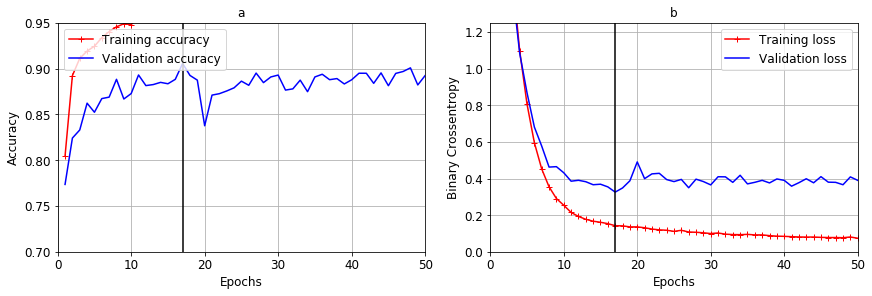

Done


In [5]:
# import a model to evaluate

N_f = 50
N_save = 1

Version = 'V4'
optim = 'loss'
Folder = 'CRNN_3chan'
Model = 'CRNN_3chan'

# load and plot its history

History_eval = np.load('saved_models_' + Folder + '/History_Save_' + Model + '_' + str(N_f) + 'ep_' + Version + '.npy')

acc = History_eval[0]
val_acc = History_eval[1]
loss = History_eval[2]
val_loss = History_eval[3]

N_lim = 100

Optim_loss = (np.argmin(val_loss[N_save-1:N_lim:N_save])+1)*N_save
Optim_acc = (np.argmax(val_acc[N_save-1:N_lim:N_save])+1)*N_save
print('Best loss at : ', Optim_loss, 'Epochs (', val_loss[Optim_loss-1], ')')
print('Best accuracy at : ', Optim_acc, 'Epochs (', val_acc[Optim_acc-1], ')')

if optim == 'loss':
    
    Ind = Optim_loss
    print('Model loaded : ', Ind, 'Epochs')
    print('Model specs : VAL LOSS : ', val_loss[Ind-1], ', VAL ACC : ', val_acc[Ind-1])

    model_eval = models.load_model('saved_models_' + Folder + '/' + Model + '_model_' + str(Ind) + 'ep_' + Version + '.h5')
    
else:
    
    Ind = Optim_acc
    print('Model loaded : ', Ind, 'Epochs')
    print('Model specs : VAL LOSS : ', val_loss[Ind-1], ', VAL ACC : ', val_acc[Ind-1])

    model_eval = models.load_model('saved_models_' + Folder + '/' + Model + '_model_' + str(Ind) + 'ep_' + Version + '.h5')


epochs = range(1,len(acc)+1)

print('Done')

fig = plt.figure(constrained_layout=True, figsize=(12, 4))
gs = gridspec.GridSpec(1, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(epochs, acc, '+-r', label='Training accuracy')
ax1.plot(epochs, val_acc, 'b', label='Validation accuracy')
ax1.plot([Ind, Ind], [0.7, 0.95], 'k')
ax1.set_ylim([0.7, 0.95])
ax1.set_xlim([0, N_f])
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('a')
ax1.grid(axis='both')
ax1.tick_params(axis='both', labelsize='12')
ax1.legend(fontsize='12', loc='upper left')

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(epochs, loss, '+-r', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.plot([Ind, Ind], [0, 1.25], 'k')
ax2.set_ylim([0, 1.25])
ax2.set_xlim([0, N_f])
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Binary Crossentropy', fontsize=12)
ax2.set_title('b')
ax2.grid(axis='both')
ax2.tick_params(axis='both', labelsize='12')
ax2.legend(fontsize='12', loc='upper right')

plt.show()

print('Done')

# PREDICT ON A ROLLING WINDOW

In [28]:
Nt = OP_input_tot.shape[1]
Fs = 10000
dt = 1/Fs
Tt = Nt/Fs

Dt = 0.3
Dx = int(Nt*Dt/Tt)

x1 = 0
x2 = Dx
step = int(0.02*Fs)
Threshold = 0.5

t0 = x2/Nt * Tt
t_pred = [t0]
pred_state_list = []
pred_unst_list = []
time_list = []

Neigh = 4

c1 = 1
NC = (Nt-Dx) // 1000 + 1

T0 = time.time()

RMS = []

#Patch n Channels
def to_nCH(X, n):
    Y = np.zeros((X.shape[0], X.shape[1], n))
    
    if n == 3:
        Y = X
        
    elif n == 2:
        Y[:,:,0] = X[:,:,0]
        Y[:,:,1] = X[:,:,2]
        
    elif n == 1:
        Y[:,:,0] = X[:,:,0]
    
    else:
        print('Err : Invalid number of channel : n=1, n=2 or n=3')
        sys.exit()
    
    return Y

#NUMBER OF CHANNELS
n = 3

while x2 < Nt:
    
    c2 = x1 // 1000 + 1
    if c1 != c2:
        print(c2, '/', NC, end="\r")
        c1 = c2
    
    Input_RW = np.copy(OP_input_tot[:,x1:x2,:])
    
    Chan1 = Input_RW[:,:,0]-np.mean(Input_RW[:,:,0])
    Chan1 = Chan1/np.max(np.abs(Chan1))
    Chan2 = Input_RW[:,:,1]-np.mean(Input_RW[:,:,1])
    Chan2 = Chan2/np.max(np.abs(Chan2))
    Chan3 = Input_RW[:,:,2]-np.mean(Input_RW[:,:,2])
    Chan3 = Chan3/np.max(np.abs(Chan3))
    
    RMS += [np.max(np.abs(Chan1[0,:]))/np.sqrt(np.mean(np.power(Chan1[0,:],2)))]
    
    Input_RW[:,:,0] = Chan1
    Input_RW[:,:,1] = Chan2
    Input_RW[:,:,2] = Chan3
    
    t1 = time.time()
    
    Input_RW_nCH = to_nCH(Input_RW, n)
    
    pred_unst = model_eval.predict(Input_RW_nCH)
    
    x1 += step
    x2 += step
    
    t2 = time.time()
    
    pred_unst_list += [pred_unst]
    t_pred += [t_pred[-1] + step*dt]
    time_list += [t2-t1]
    
TF = time.time()

print(c2, '/', NC)
print('Total Time', TF-T0)
print('Done')

100 / 100
Total Time 10.789666891098022
Done


In [27]:
print(np.mean(time_list))

0.027831160068511964


# PLOT THE PREDICTION

In [29]:
L = 0
H = 10.3

t = np.linspace(0, Tt, Nt)

t_pred_arr = np.array(t_pred)-Dt/2
pred_unst_arr = np.array(pred_unst_list)

print('Done')

Done


mean UP 0.9879435
mean LEFT 0.024330681
mean RIGHT 0.8724406
mean DOWN 0.0038104646


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


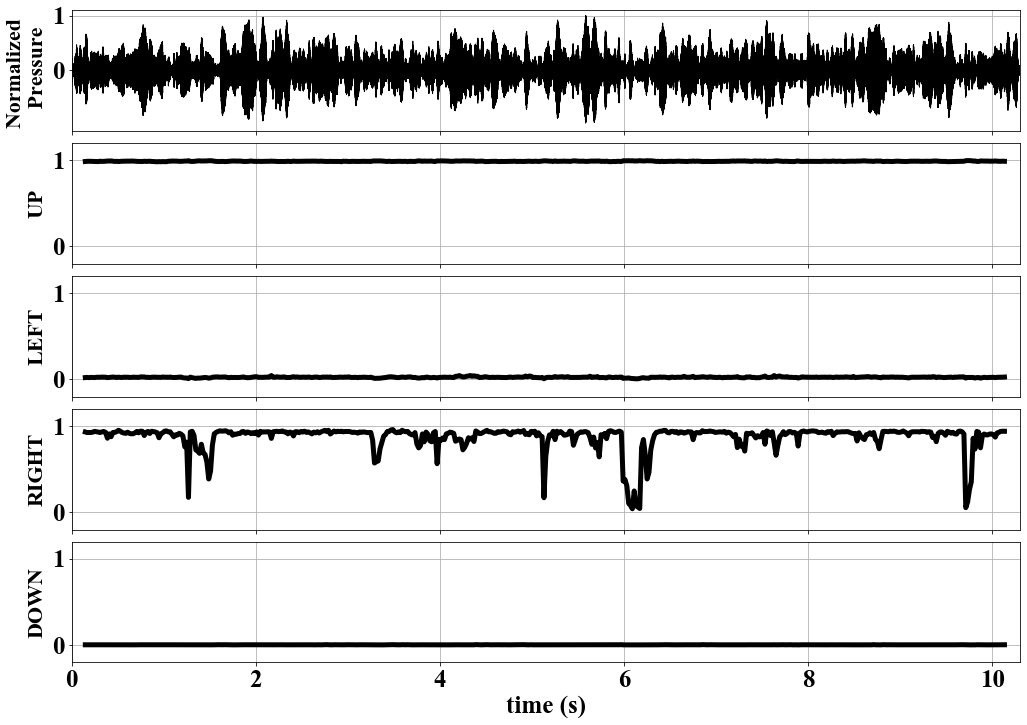

In [30]:
csfont = {'fontname':'Times New Roman'}

print('mean UP', np.mean(pred_unst_arr[:,:,0]))
print('mean LEFT', np.mean(pred_unst_arr[:,:,3]))
print('mean RIGHT', np.mean(pred_unst_arr[:,:,1]))
print('mean DOWN', np.mean(pred_unst_arr[:,:,2]))


fig = plt.figure(constrained_layout=True, figsize=(17, 12))
gs = gridspec.GridSpec(5, 1, figure=fig)

#SIGNAL
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t, OP_input_tot[0,:,0] / max(abs(OP_input_tot[0,:,0])) , '-k', LineWidth=1)#, s=30, marker='+', color='k')
#ax1.plot([L, H], [Score_gt[0],Score_gt[0]], color='r', label='Ground Truth', linewidth=2)
ax1.grid(axis='both')
#ax1.legend(fontsize=18)
#ax1.set_xlabel('time (s)', fontsize=25)
ax1.set_ylabel('Normalized \n Pressure', color='k', **csfont, fontsize=22)
ax1.set_yticks([0,1])
ax1.set_xticks(np.arange(0, 10.3, 2))
ax1.tick_params(axis='both', which='both', top=False, right=False, labelbottom=False, labelsize = 25)
#ax1.set_title('(b)', fontsize=25)
ax1.set_xlim([L, H])
ax1.set_ylim([-1.1, 1.1])

for tick in ax1.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Times New Roman")

#UP
ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(t_pred_arr[:len(t_pred_arr)-1], pred_unst_arr[:,:,0], '-k', LineWidth=5)#, s=30, marker='+', color='k')
#ax1.plot([L, H], [Score_gt[0],Score_gt[0]], color='r', label='Ground Truth', linewidth=2)
ax1.grid(axis='both')
#ax1.legend(fontsize=18)
#ax1.set_xlabel('time (s)', fontsize=25)
ax1.set_ylabel('UP', color='k', **csfont, fontsize=22)
ax1.set_yticks([0,1])
ax1.set_xticks(np.arange(0, 10.3, 2))
ax1.tick_params(axis='both', which='both', top=False, right=False, labelbottom=False, labelsize = 25)
#ax1.set_title('(b)', fontsize=25)
ax1.set_xlim([L, H])
ax1.set_ylim([-0.2, 1.2])

for tick in ax1.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Times New Roman")
    
#LEFT
ax2 = fig.add_subplot(gs[2, 0])
ax2.plot(t_pred_arr[:len(t_pred_arr)-1], pred_unst_arr[:,:,3], '-k', LineWidth=5)#, s=30, marker='+', color='k')
#ax2.plot([L, H], [Score_gt[3],Score_gt[3]], color='r', label='Ground Truth', linewidth=2)
ax2.grid(axis='both')
#ax2.legend(fontsize=18)
#ax2.set_xlabel('time (s)', **csfont, fontsize=25)
ax2.set_ylabel('LEFT', color='k', **csfont, fontsize=22)
ax2.set_yticks([0,1])
ax2.set_xticks(np.arange(0, 10.3, 2))
ax2.tick_params(axis='both', which='both', top=False, right=False, labelbottom=False, labelsize = 25)
#ax2.set_title('(b)', fontsize=25)
ax2.set_xlim([L, H])
ax2.set_ylim([-0.2, 1.2])

for tick in ax2.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Times New Roman")

#RIGHT
ax3 = fig.add_subplot(gs[3, 0])
ax3.plot(t_pred_arr[:len(t_pred_arr)-1], pred_unst_arr[:,:,1], '-k', LineWidth=5)#, s=30, marker='+', color='k')
#ax3.plot([L, H], [Score_gt[1],Score_gt[1]], color='r', label='Ground Truth', linewidth=2)
ax3.grid(axis='both')
#ax3.legend(fontsize=18)
#ax3.set_xlabel('time (s)', fontsize=25)
ax3.set_ylabel('RIGHT', color='k', **csfont, fontsize=22)
ax3.set_yticks([0,1])
ax3.set_xticks(np.arange(0, 10.3, 2))
ax3.tick_params(axis='both', which='both', top=False, right=False, labelbottom=False, labelsize = 25) 
#ax3.set_title('(b)', fontsize=25)
ax3.set_xlim([L, H])
ax3.set_ylim([-0.2, 1.2])

for tick in ax3.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax3.get_yticklabels():
    tick.set_fontname("Times New Roman")

#DOWN
ax4 = fig.add_subplot(gs[4, 0])
ax4.plot(t_pred_arr[:len(t_pred_arr)-1], pred_unst_arr[:,:,2], '-k', LineWidth=5)#, s=30, marker='+', color='k')
#ax4.plot([L, H], [Score_gt[2],Score_gt[2]], color='r', label='Ground Truth', linewidth=2)
ax4.grid(axis='both')
#ax4.legend(fontsize=18)
ax4.set_xlabel('time (s)', **csfont, fontsize=25)
ax4.set_ylabel('DOWN', color='k', **csfont, fontsize=22)
ax4.set_yticks([0,1])
ax4.set_xticks(np.arange(0, 10.3, 2))
ax4.tick_params(axis='both', which='both', top=False, right=False, labelsize = 25)
#ax4.set_title('(b)', fontsize=25)
ax4.set_xlim([L, H])
ax4.set_ylim([-0.2, 1.2])

for tick in ax4.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax4.get_yticklabels():
    tick.set_fontname("Times New Roman")



plt.subplots_adjust(hspace=0.1)